In [127]:
%matplotlib inline
import numpy as np
import GPy
from pylab import *
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

In [166]:
def forrester(X):
    return((6*X -2)**2)*np.sin(12*X-4)

from matplotlib import pyplot as plt

def ax_default(fignum, ax):
    if ax is None:
        fig = plt.figure(fignum)
        ax = fig.add_subplot(111)
    else:
        fig = ax.figure
    return fig, ax

def meanplot(x, mu, color='#3300FF', ax=None, fignum=None, linewidth=2,**kw):
    _, axes = ax_default(fignum, ax)
    return axes.plot(x,mu,color=color,linewidth=linewidth,**kw)

def gpplot(x, mu, lower, upper, edgecol='#3300FF', fillcol='#33CCFF', ax=None, fignum=None, **kwargs):
    _, axes = ax_default(fignum, ax)

    mu = mu.flatten()
    x = x.flatten()
    lower = lower.flatten()
    upper = upper.flatten()

    plots = []

    #here's the mean
    plots.append(meanplot(x, mu, edgecol, axes))

    #here's the box
    kwargs['linewidth']=0.5
    if not 'alpha' in kwargs.keys():
        kwargs['alpha'] = 0.3
    plots.append(axes.fill(np.hstack((x,x[::-1])),np.hstack((upper,lower[::-1])),color=fillcol,**kwargs))

    #this is the edge:
    plots.append(meanplot(x, upper,color=edgecol, linewidth=0.2, ax=axes))
    plots.append(meanplot(x, lower,color=edgecol, linewidth=0.2, ax=axes))

    return plots

## A GP Regression Example

In [129]:
np.random.seed(0)
N =8
X = np.random.rand(N, 1)
Y = forrester(X) + np.random.randn(N,1)*0.01

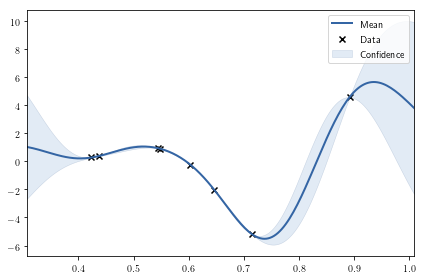

In [130]:
m = GPy.models.GPRegression(X, Y, noise_var=0.0001)
m.optimize()
fig = figure(figsize=(6,4))
ax = fig.gca()
m.plot(ax=ax)
fig.tight_layout()
#fig.savefig('../diagrams/gp_first_example.pdf')

## GP runtime scaling behavior

In [78]:
import time
Ns = [10, 100, 500, 1000, 1500, 2000]
times = []
for N in Ns:
    X = np.random.rand(N, 1)
    Y = forrester(X) + np.random.randn(N,1)*0.01
    m = GPy.models.GPRegression(X, Y)
    time_start = time.time()
    m._trigger_params_changed()
    time_end = time.time()
    times.append(time_end - time_start)

In [81]:
times

[0.0013208389282226562,
 0.008491992950439453,
 0.02819991111755371,
 0.12454509735107422,
 0.28645873069763184,
 0.7615067958831787]

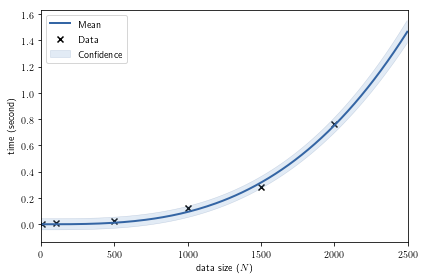

In [83]:
m2 = GPy.models.GPRegression(np.array(Ns)[:,None], np.array(times)[:,None], kernel=GPy.kern.Poly(1, order=3))
m2.likelihood.variance = 1e-3
m2.optimize()
fig = figure(figsize=(6,4))
ax = fig.gca()
m2.plot(ax=ax)
ax.set_xlim(0,2500)
ax.set_xlabel('data size ($N$)')
ax.set_ylabel('time (second)')
fig.tight_layout()
# fig.savefig('../diagrams/gp_scaling.pdf')

In [107]:
Ns

[10, 100, 500, 1000, 1500, 2000]

In [108]:
times

[0.0013208389282226562,
 0.008491992950439453,
 0.02819991111755371,
 0.12454509735107422,
 0.28645873069763184,
 0.7615067958831787]

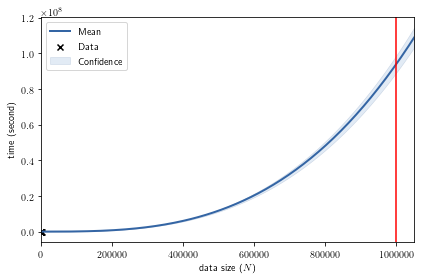

In [105]:
fig = figure(figsize=(6,4))
ax = fig.gca()
m2.plot(ax=ax, plot_limits=[0, 1050000])
ax.set_xlim(0,1050000)
ax.set_xlabel('data size ($N$)')
ax.set_ylabel('time (second)')
y_1m_mean, y_1m_var = m2.predict(np.array([[1e6]]))
# ax.plot([1e6], y_1m_mean, 'rx')
ax.axvline(x=1e6, c='r')
fig.tight_layout()
fig.savefig('../diagrams/gp_scaling_1m.png', dpi=300)

In [100]:
y_1m_mean[0][0]/3600/24/365

2.98064607245486

In [121]:
y_1m_mean[0][0]/1.2**50 /3600

2.869143129630352

In [ ]:
c/(s*f)

In [111]:
1.2**100

82817974.52201425

In [ ]:
1.2**100

In [ ]:
c*2/

In [ ]:
(1.2)**x = 2

In [ ]:
x log1.2 = log 2

In [124]:
x = np.log(2**3)/np.log(1.2)

In [125]:
x

11.405352050771793

## A quick GP log-likelihood profiling

In [7]:
from scipy.linalg.lapack import dtrtrs
def compute_log_likelihood(kern, X, Y, sigma2):
    N = X.shape[0]
    K = kern.K(X)
    Ky = K + np.eye(N)*sigma2
    L = np.linalg.cholesky(Ky)
    LinvY = dtrtrs(L, Y, lower=1)[0]
    logL = N*np.log(2*np.pi)/-2.
    logL += np.square(LinvY).sum()/-2.
    logL += -np.log(np.diag(L)).sum()
    return logL

__Run the following Python code. (line_profiler is required.)__
```python
X = np.random.rand(1000,10)
Y = np.random.rand(1000,1)
k = GPy.kern.RBF(10)
sigma2 = 0.01
%load_ext line_profiler
%lprun -f compute_log_likelihood compute_log_likelihood(k, X, Y, sigma2)
```


__The outcome is as follows:__

Timer unit: 1e-06 s

Total time: 0.094684 s
File: <ipython-input-12-507b55833290>
Function: compute_log_likelihood at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     2                                           def compute_log_likelihood(kern, X, Y, sigma2):
     3         1          6.0      6.0      0.0      N = X.shape[0]
     4         1      55595.0  55595.0     58.7      K = kern.K(X)
     5         1       4369.0   4369.0      4.6      Ky = K + np.eye(N)*sigma2
     6         1      30012.0  30012.0     31.7      L = np.linalg.cholesky(Ky)
     7         1       4361.0   4361.0      4.6      LinvY = dtrtrs(L, Y, lower=1)[0]
     8         1         49.0     49.0      0.1      logL = N*np.log(2*np.pi)/-2.
     9         1         82.0     82.0      0.1      logL += np.square(LinvY).sum()/-2.
    10         1        208.0    208.0      0.2      logL += -np.log(np.diag(L)).sum()
    11         1          2.0      2.0      0.0      return logL

## Normal GP and Sparse GP with a lot of data

In [131]:
np.random.seed(0)
N =100
X = np.random.randn(N, 1)/4.+.5
Y = forrester(X) + np.random.randn(N,1)*1.

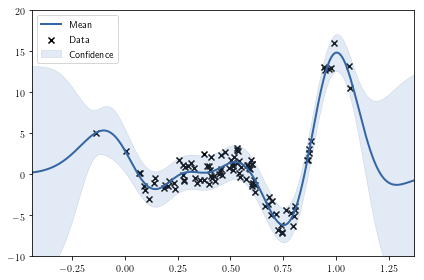

In [44]:
m = GPy.models.GPRegression(X, Y, noise_var=0.0001)
m.kern.lengthscale = .3
m.likelihood.variance = 0.01
m.optimize()
fig = figure(figsize=(6,4))
ax = fig.gca()
m.plot(ax=ax)
ax.set_ylim(-10,20)
fig.tight_layout()
fig.savefig('../diagrams/gp_example_lots_data_uneven.png')

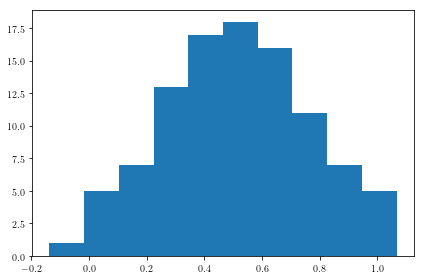

In [56]:
fig = figure(figsize=(6,4))
ax = fig.gca()
ax.hist(X,10)
fig.tight_layout()
fig.savefig('../diagrams/X_histogram_lots_data_uneven.png', dpi=300)

In [134]:
np.random.seed(0)
N =100
X = np.random.randn(N, 1)/4.+.5
X = np.sort(X,axis=0)
Y = forrester(X) + np.random.randn(N,1)*1.

In [77]:
K = m.kern.K(X)
eigv = np.linalg.eigvalsh(K)

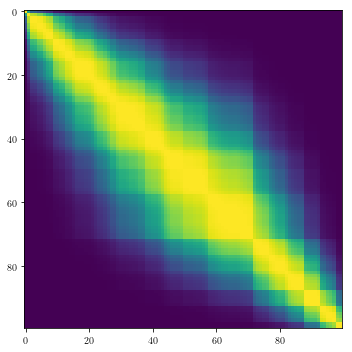

In [78]:
fig = figure(figsize=(5,5))
ax = fig.gca()
ax.imshow(K, interpolation=None)
fig.tight_layout()
fig.savefig('../diagrams/lots_data_covariance_matrix.png', dpi=300)

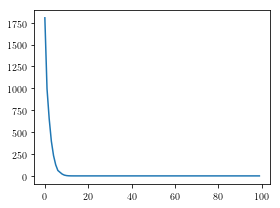

In [79]:
fig = figure(figsize=(4,3))
ax = fig.gca()
ax.plot(eigv[::-1])
fig.tight_layout()
fig.savefig('../diagrams/lots_data_eigen_values.png', dpi=300)

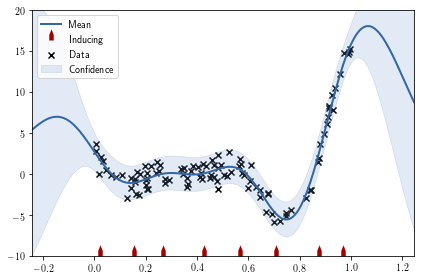

In [10]:
m = GPy.models.SparseGPRegression(X, Y, num_inducing=8)
m.likelihood.variance = 1e-4
m.optimize()
fig = figure(figsize=(6,4))
ax = fig.gca()
m.plot(ax=ax)
ax.set_ylim(-10,20)
fig.tight_layout()
fig.savefig('../diagrams/sparsegp_example_lots_data.pdf')

## Too many inducing points

In [25]:
np.random.seed(0)
N =8
X = np.random.rand(N, 1)
Y = forrester(X) + np.random.randn(N,1)*0.01

('defaulting to ', <GPy.inference.latent_function_inference.var_dtc.VarDTC object at 0x116265940>, 'for latent function inference')


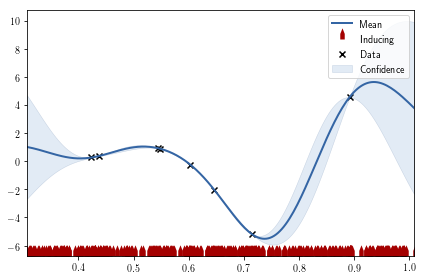

In [26]:
# Force sparse GP to take a lot of inducing points.
m = GPy.core.SparseGP(X, Y, np.random.rand(500,1), GPy.kern.RBF(1), GPy.likelihoods.Gaussian(variance=0.01))
m.likelihood.variance = 1e-4
m.optimize()
fig = figure(figsize=(6,4))
ax = fig.gca()
m.plot(ax=ax)
fig.tight_layout()
fig.savefig('../diagrams/sparsegp_example_lots_inducing_points.pdf')

In [161]:
from mxnet import gluon
from mxnet.initializer import Xavier

num_hidden = 10
net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(num_hidden, in_units=1,activation="tanh"))
net.add(gluon.nn.Dense(num_hidden, in_units=num_hidden,activation="tanh"))
net.add(gluon.nn.Dense(1, in_units=num_hidden))
net.initialize(Xavier())

In [136]:
import mxnet as mx
from mxnet import autograd

trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': .01})
X_mx = mx.nd.array(X)
Y_mx = mx.nd.array(Y)

for i in range(1000):
    with autograd.record():
        output = net(X_mx)
        loss = ((output-Y_mx)**2).sum()
    loss.backward()
    trainer.step(1)

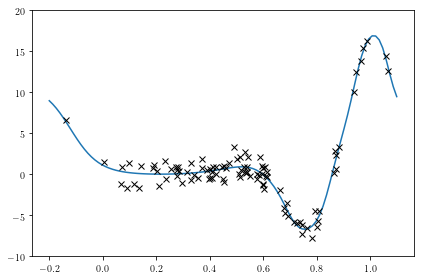

In [137]:
x_test = np.linspace(-0.2, 1.1, 100)
y_test = net(mx.nd.array(x_test)).asnumpy()
fig = figure(figsize=(6,4))
ax = fig.gca()
ax.plot(x_test, y_test)
ax.plot(X, Y, 'kx')
ax.set_ylim(-10,20)
fig.tight_layout()
# fig.savefig('../diagrams/lots_data_nn_fit.png', dpi=300)

In [ ]:
gpplot()

In [162]:
import mxnet as mx
from mxnet import autograd

X_mx = mx.nd.array(X)
Y_mx = mx.nd.array(Y)
params = net.collect_params()
sigma2_bt = params.get('sigma2', shape=(1,), init = mx.initializer.Constant(mx.nd.array([0.01])))
params.initialize()


trainer = gluon.Trainer(params, 'adam', {'learning_rate': .01})

for i in range(1000):
    with autograd.record():
        output = net(X_mx)
        sigma2_bt = params.get('sigma2').data()
        sigma2 = mx.nd.exp(sigma2_bt)
        loss = -(-((output-Y_mx)**2)/(2*sigma2) + mx.nd.log(2*np.pi*sigma2)/-2).sum()
    loss.backward()
    trainer.step(1)

 /Users/zhenwend/anaconda3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:813: UserWarning:Parameter 'dense9_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
 /Users/zhenwend/anaconda3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:813: UserWarning:Parameter 'dense9_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
 /Users/zhenwend/anaconda3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:813: UserWarning:Parameter 'dense10_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
 /Users/zhenwend/anaconda3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:813: UserWarning:Parameter 'dense10_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
 /Users/zhenwend/anaconda3/lib/python3.6/site-packages/mxnet/gluon/parameter.py:813: UserWarning:Parameter 'dense11_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
 /Users/zhenwend

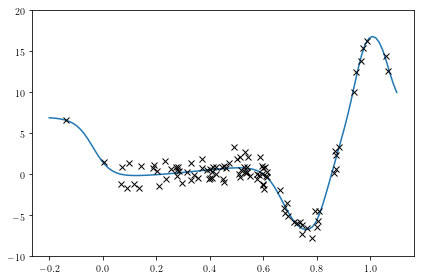

In [164]:
x_test = np.linspace(-0.2, 1.1, 100)
y_test = net(mx.nd.array(x_test)).asnumpy()
fig = figure(figsize=(6,4))
ax = fig.gca()
ax.plot(x_test, y_test)
ax.plot(X, Y, 'kx')
ax.set_ylim(-10,20)
fig.tight_layout()

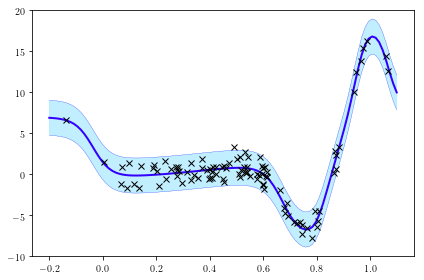

In [171]:
sigma = np.sqrt(np.exp(params.get('sigma2').data().asnumpy()))
fig = figure()
ax = fig.gca()
gpplot(x_test, y_test, y_test-2*sigma, y_test+2*sigma, ax=ax)
ax.plot(X, Y, 'kx')
ax.set_ylim(-10,20)
fig.tight_layout()
fig.savefig('../diagrams/lots_data_nn_fit_with_noise.png', dpi=300)

## Time-series Example

In [56]:
np.random.seed(0)
k = GPy.kern.Exponential(1)
x = np.linspace(0, 100, 1000)[:,None]
cov = k.K(x)
L = GPy.util.linalg.jitchol(cov)
a = np.random.randn(1000)[:,None]
s = L.dot(a)

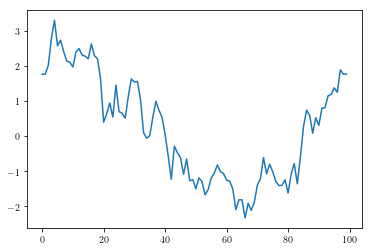

In [57]:
plot(s[:100])

In [58]:
m1 = GPy.models.GPRegression(x[:10], s[:10], kernel=GPy.kern.Exponential(1))
m1.likelihood.variance = 0.01
m1.optimize()
print(m1)


Name : GP regression
Objective : 7.2404709935640446
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  Exponential.variance     |       4.154976462152585  |      +ve      |        
  Exponential.lengthscale  |      4.4637318394462095  |      +ve      |        
  Gaussian_noise.variance  |  2.6748730702773884e-07  |      +ve      |        


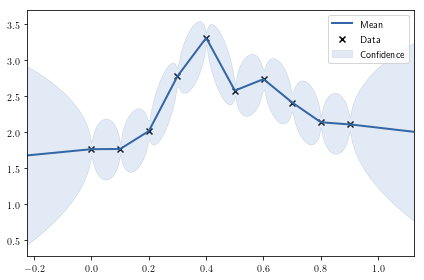

In [72]:
fig = figure()
ax = fig.gca()
m1.plot(ax=ax)
fig.tight_layout()
fig.savefig('../diagrams/time_series_10.png', dpi=300)

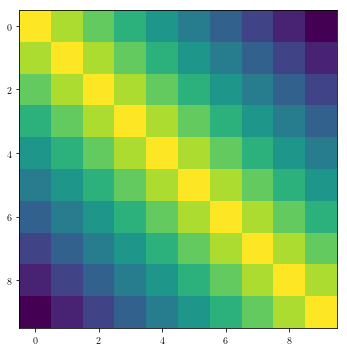

In [65]:
fig = figure(figsize=(5,5))
ax = fig.gca()
ax.imshow(m1.kern.K(m1.X), interpolation=None)
fig.tight_layout()
fig.savefig('../diagrams/time_series_cov_10.png', dpi=300)

In [66]:
m2 = GPy.models.GPRegression(x[:100], s[:100], kernel=GPy.kern.Exponential(1))
m2.likelihood.variance = 0.01
m2.optimize()
print(m2)


Name : GP regression
Objective : 55.99971821825051
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  Exponential.variance     |    2.4150080193938073  |      +ve      |        
  Exponential.lengthscale  |    2.7799198761868626  |      +ve      |        
  Gaussian_noise.variance  |  0.003654924339284842  |      +ve      |        


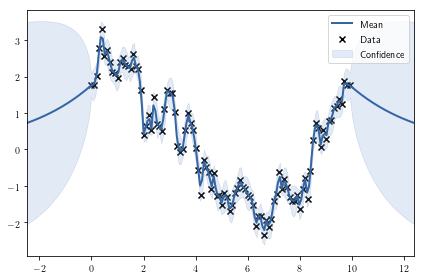

In [67]:
fig = figure()
ax = fig.gca()
m2.plot(ax=ax)
fig.tight_layout()
fig.savefig('../diagrams/time_series_100.png', dpi=300)

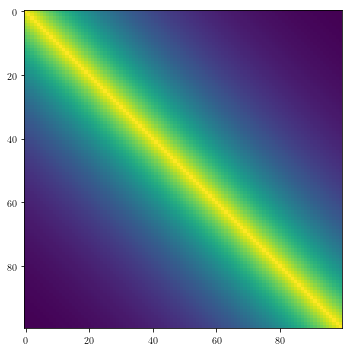

In [68]:
fig = figure(figsize=(5,5))
ax = fig.gca()
ax.imshow(m2.kern.K(m2.X), interpolation=None)
fig.tight_layout()
fig.savefig('../diagrams/time_series_cov_100.png', dpi=300)

In [69]:
m3 = GPy.models.GPRegression(x[:1000], s[:1000], kernel=GPy.kern.Exponential(1))
m3.likelihood.variance = 0.01
m3.optimize()
print(m3)


Name : GP regression
Objective : 551.6143218651176
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  Exponential.variance     |     1.214495593568315  |      +ve      |        
  Exponential.lengthscale  |    1.4466786763487873  |      +ve      |        
  Gaussian_noise.variance  |  0.010535713106078913  |      +ve      |        


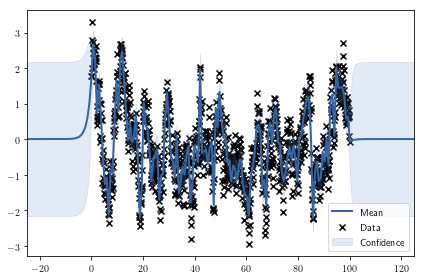

In [70]:
fig = figure()
ax = fig.gca()
m3.plot(ax=ax)
fig.tight_layout()
fig.savefig('../diagrams/time_series_1000.png', dpi=300)

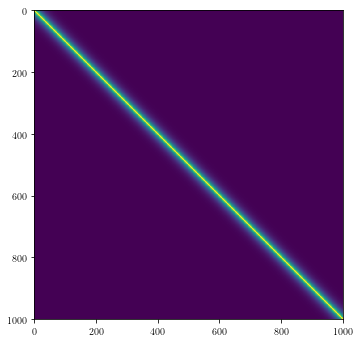

In [71]:
fig = figure(figsize=(5,5))
ax = fig.gca()
ax.imshow(m3.kern.K(m3.X), interpolation=None)
fig.tight_layout()
fig.savefig('../diagrams/time_series_cov_1000.png', dpi=300)